<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1lfulldataset_splitting_modeling_decisiontree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
Split Xq1 and yq1 into 80-20 train validation split.
save them as separate. 

looking at
1. log reg
2. decision tree
3. skipping svm and knn.
4. random forest
5. adaboost
6. xgboost
7. neural net dense in keras

compare best performances for each type of model. 

Getting yq1 and Xq1:

Getting yq1 from datadfq1

In [2]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Getting saved yq1 from drive:

Gatting Xq1 from drive

In [3]:
Xq1 = decompress_pickle(path_name+"Xq1all.pbz2") 
yq1 = decompress_pickle(path_name+"yq1all.pbz2") 

In [4]:
type(Xq1), type(yq1)

(scipy.sparse.coo.coo_matrix, pandas.core.series.Series)

In [5]:
from scipy.sparse import coo_matrix

In [6]:
Xq1.shape, yq1.shape

((7313354, 2233), (7313354,))

splitting into 80-20 training and validation set with a random state = 5. (had to remove stratify argument, because it doesn't work for sparse arrays)

In [7]:
from sklearn.model_selection import train_test_split

Xq1_train, Xq1_valid, yq1_train, yq1_valid = train_test_split(Xq1,yq1,test_size=0.2,random_state=5)

In [8]:
Xq1_train.shape, Xq1_valid.shape, yq1_train.shape, yq1_valid.shape

((5850683, 2233), (1462671, 2233), (5850683,), (1462671,))

Fraction of ones in the train and validation sets

In [9]:
yq1_train.sum()/yq1_train.shape[0], yq1_valid.sum()/yq1_valid.shape[0]

(0.1611603294863181, 0.16108748994134703)

They are about the same, we will use this split to test a number of models. They are saved below:

First, we scale and transform the data using the min-max scaler. 

In [10]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MaxAbsScaler()

mm_scaler.fit(Xq1_train)
Xq1_mm_train = mm_scaler.transform(Xq1_train)
Xq1_mm_valid = mm_scaler.transform(Xq1_valid)


### Decision tree classifier
 


In [38]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=9)
dtree.fit(Xq1_train,yq1_train)

DecisionTreeClassifier(max_depth=9)

In [45]:
yq1_train_preds_proba = dtree.predict_proba(Xq1_train)[:,1]
yq1_valid_preds_proba = dtree.predict_proba(Xq1_valid)[:,1]

In [40]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, roc_auc_score


In [41]:
accuracy_score(yq1_valid,np.where(yq1_valid_preds_proba>0.5,1,0))

0.8398395811498279

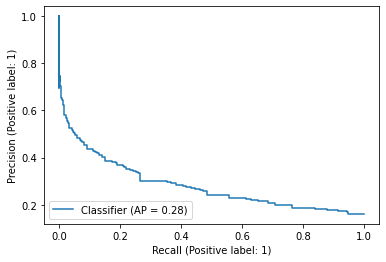

In [46]:
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_proba)

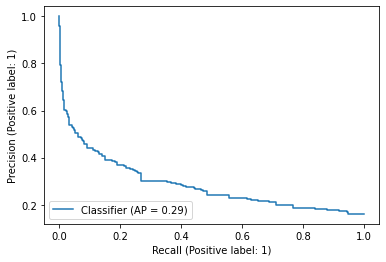

In [47]:
PrecisionRecallDisplay.from_predictions(yq1_train,yq1_train_preds_proba)

In [44]:
roc_auc_score(yq1_valid,yq1_valid_preds_proba)

0.6512656160788077

In [37]:
compressed_pickle(path_name+"Decisiontreemd9_q1_1",dtree)

In [ ]:
from sklearn.model_selection import ShuffleSplit
#cv = KFold(n_splits=5, test_size=0.3, random_state=0)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

# iterate over 
logreg = LogisticRegression(max_iter = 100,solver='liblinear',verbose=10,penalty='l1')
logreg.fit(Xq1_mm_train,yq1_train)
yq1_train_preds = logreg.predict(Xq1_mm_train)

#scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

#cv_results = cross_validate(logreg,Xq1_mm_train,yq1_train,cv=cv,scoring=scoring_metrics,verbose=10,return_estimator = True)

#sorted(cv_results.keys())

[LibLinear]

TypeError: ignored

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 5,subsample = 0.5)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.8408690367669401
XG Boost test set score: 0.8364779874213837


In [ ]:
y_train.value_counts(normalize=True)

0    0.838074
1    0.161926
Name: p_forgot_bin, dtype: float64

In [ ]:
y_probaXGB = XGB_model.predict_proba(X_mm_test)[:,1]

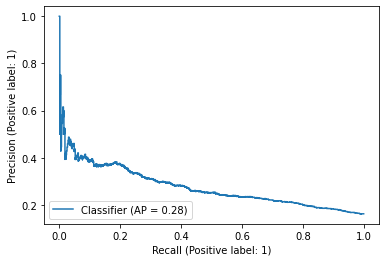

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier(n_estimators=150, learning_rate=1)

AB_model.fit(X_train_unscaled,y_train)
y_probaAB = AB_model.predict_proba(X_test_unscaled)[:,1]

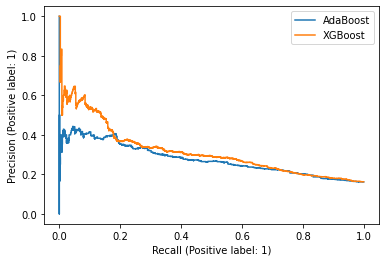

In [ ]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
plt.figure()
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test,y_probaAB,ax=ax,label="AdaBoost")
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB,ax=ax,label="XGBoost")
plt.legend()
plt.show()

In [ ]:
pd.Series(dict(zip(X_test_unscaled.columns,AB_model.feature_importances_))).sort_values(ascending=False).head(10)

delta           0.046667
session_seen    0.046667
history_frac    0.040000
history_seen    0.020000
dos             0.013333
fa              0.006667
form            0.006667
ff              0.006667
fes             0.006667
fami            0.006667
dtype: float64

Take a subset of 20,000, and use all features. expect around baseline accuracy. 

In [ ]:
q1lexemes['sf_length']

0         4
1         5
2         3
3         5
4         1
         ..
12155     5
12156    10
12157     5
12158     3
12159     9
Name: sf_length, Length: 12160, dtype: int64

In [ ]:
dataffq1 = pd.merge(left = datadfq1, right = q1lexemes[['lexeme_id','sf_length']],how="left",left_on='lexeme_id',right_on='lexeme_id')

In [ ]:
dataffq1['p_forgot_bin'] = np.where(1 - dataffq1['p_recall']>0,1,0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


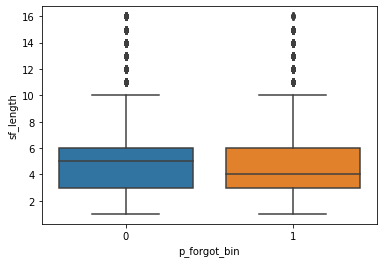

In [ ]:
sns.boxplot(dataffq1['p_forgot_bin'],dataffq1['sf_length'])